## Load dataset

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

df = pd.read_csv('data/final_f1_ml_laps_dataset.csv')
df.head()

,season,gp_name,session_name,session_type,driver,team,lap_number,lap_time,sector_1_time,sector_2_time,...,throttle_std,throttle_pct_full,brake_std,brake_pct_braking,rpm_std,gear_changes,gear_min,gear_max,drs_active_pct,drs_time_seconds
0,2023,Bahrain Grand Prix,Race,Race,VER,Red Bull Racing,1,99.019,NaN,42.414,...,43.095194,0.423684,0.402490,0.202632,1520.598745,52.0,1.0,7.0,1.0,99.381530
1,2023,Bahrain Grand Prix,Race,Race,VER,Red Bull Racing,2,97.974,31.342,42.504,...,43.626538,0.432507,0.403420,0.203857,1637.445568,43.0,2.0,8.0,1.0,97.750285
2,2023,Bahrain Grand Prix,Race,Race,VER,Red Bull Racing,3,98.006,31.388,42.469,...,43.299096,0.470109,0.388650,0.184783,1747.054894,36.0,3.0,8.0,0.0,0.000000
3,2023,Bahrain Grand Prix,Race,Race,VER,Red Bull Racing,4,97.976,31.271,42.642,...,43.281912,0.471053,0.400527,0.200000,1726.074671,39.0,3.0,8.0,0.0,0.000000
4,2023,Bahrain Grand Prix,Race,Race,VER,Red Bull Racing,5,98.035,31.244,42.724,...,43.751400,0.450549,0.405019,0.206044,1732.516039,36.0,3.0,8.0,0.0,0.000000


## Clean data

In [2]:
df = df[df['lap_time']>1].dropna(subset=['sector_1_time','sector_2_time','sector_3_time'])
print(df.shape)

(23553, 48)


## Feature grouping

In [3]:
meta_cols=['season','gp_name','session_name','driver','team']
lap_features=['lap_number','sector_1_time','sector_2_time','sector_3_time','position','track_status','is_pit_lap']
tyre_features=['compound','stint','tyre_life','fresh_tyre']
weather_features=['air_temp','track_temp','humidity','wind_speed','wind_dir','pressure']
telemetry_basic=['speed_mean','speed_max','throttle_mean','brake_mean','rpm_mean','rpm_max','drs_activations']
bonus_features=['speed_min','speed_std','speed_q1','speed_q3','speed_range','throttle_std','throttle_pct_full','brake_std','brake_pct_braking','rpm_std','gear_changes','gear_min','drs_active_pct','drs_time_seconds']
categorical_features=['driver','team','compound']
numeric_features=lap_features+weather_features+telemetry_basic+bonus_features+['stint','tyre_life','fresh_tyre']
numeric_features=[c for c in numeric_features if c in df.columns]
print(numeric_features)

['lap_number', 'sector_1_time', 'sector_2_time', 'sector_3_time', 'position', 'track_status', 'is_pit_lap', 'air_temp', 'track_temp', 'humidity', 'wind_speed', 'wind_dir', 'pressure', 'speed_mean', 'speed_max', 'throttle_mean', 'brake_mean', 'rpm_mean', 'rpm_max', 'drs_activations', 'speed_min', 'speed_std', 'speed_q1', 'speed_q3', 'speed_range', 'throttle_std', 'throttle_pct_full', 'brake_std', 'brake_pct_braking', 'rpm_std', 'gear_changes', 'gear_min', 'drs_active_pct', 'drs_time_seconds', 'stint', 'tyre_life', 'fresh_tyre']


## Preprocessing pipeline

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

X=df[categorical_features+numeric_features]
y=df['lap_time']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=42)

numeric_transform=Pipeline([('imp',SimpleImputer(strategy='median')),('sc',StandardScaler())])
cat_transform=Pipeline([('imp',SimpleImputer(strategy='most_frequent')),('oh',OneHotEncoder(handle_unknown='ignore'))])
pre=ColumnTransformer([('num',numeric_transform,numeric_features),('cat',cat_transform,categorical_features)])


## Model training

In [5]:
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

rf=RandomForestRegressor(n_estimators=300,n_jobs=-1,random_state=42)
lgbm=LGBMRegressor(n_estimators=500,learning_rate=0.05,subsample=0.9,colsample_bytree=0.9,n_jobs=-1,random_state=42)

from sklearn.pipeline import Pipeline
rf_pipe=Pipeline([('pre',pre),('model',rf)])
lgbm_pipe=Pipeline([('pre',pre),('model',lgbm)])


## Evaluation

In [6]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

def eval_model(name,pipe):
    pipe.fit(X_train,y_train)
    preds=pipe.predict(X_test)
    return dict(
        name=name,
        mae=mean_absolute_error(y_test,preds),
        rmse=mean_squared_error(y_test,preds,squared=False),
        r2=r2_score(y_test,preds),
        preds=preds,
        pipe=pipe
    )

rf_res=eval_model("RandomForest",rf_pipe)
lgbm_res=eval_model("LightGBM",lgbm_pipe)

rf_res, lgbm_res

c:\Users\shrey\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6402
[LightGBM] [Info] Number of data points in the train set: 20020, number of used features: 74
[LightGBM] [Info] Start training from score 91.106446


c:\Users\shrey\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


({'name': 'RandomForest',
  'mae': 0.19421174261722898,
  'rmse': 0.8256939553765609,
  'r2': 0.9961113239661883,
  'preds': array([ 87.08284333, 100.44490333,  74.58712667, ...,  90.50636333,
          76.98776   , 107.50604   ]),
  'pipe': Pipeline(steps=[('pre',
                   ColumnTransformer(transformers=[('num',
                                                    Pipeline(steps=[('imp',
                                                                     SimpleImputer(strategy='median')),
                                                                    ('sc',
                                                                     StandardScaler())]),
                                                    ['lap_number',
                                                     'sector_1_time',
                                                     'sector_2_time',
                                                     'sector_3_time', 'position',
                                         

## Comparison table

In [7]:
import pandas as pd
cmp=pd.DataFrame([
    {'Model':'RandomForest','MAE':rf_res['mae'],'RMSE':rf_res['rmse'],'R2':rf_res['r2']},
    {'Model':'LightGBM','MAE':lgbm_res['mae'],'RMSE':lgbm_res['rmse'],'R2':lgbm_res['r2']}
])
cmp

,Model,MAE,RMSE,R2
0,RandomForest,0.194212,0.825694,0.996111
1,LightGBM,0.266628,0.663674,0.997488


## Residual plots

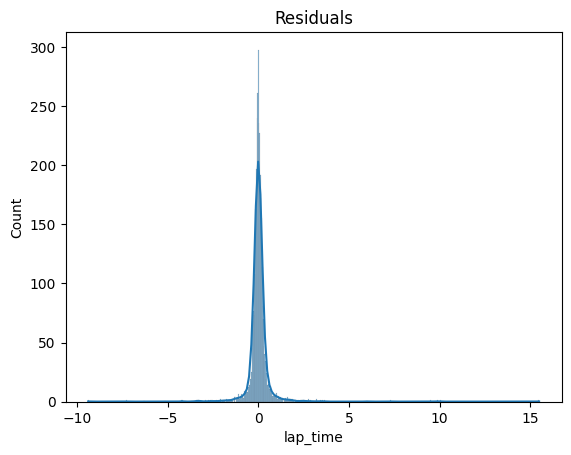

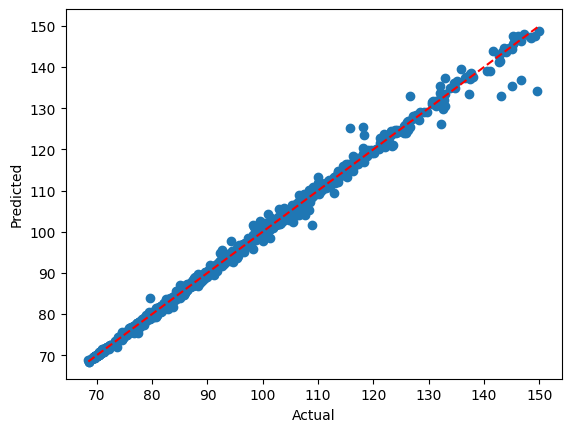

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

best=lgbm_res if lgbm_res['rmse']<rf_res['rmse'] else rf_res
residuals=y_test-best['preds']

plt.figure();sns.histplot(residuals,kde=True);plt.title("Residuals")
plt.figure();plt.scatter(y_test,best['preds']);plt.xlabel('Actual');plt.ylabel('Predicted');plt.plot([y_test.min(),y_test.max()],[y_test.min(),y_test.max()],'r--')


## Feature importance

In [9]:
final=best['pipe']
final.fit(X_train,y_train)
model=final.named_steps['model']
fn=final.named_steps['pre'].get_feature_names_out()

imp=pd.DataFrame({'feature':fn,'importance':model.feature_importances_}).sort_values('importance',ascending=False)
imp.head(20)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6402
[LightGBM] [Info] Number of data points in the train set: 20020, number of used features: 74
[LightGBM] [Info] Start training from score 91.106446


,feature,importance
1,num__sector_1_time,1975
3,num__sector_3_time,1907
2,num__sector_2_time,1784
22,num__speed_q1,861
30,num__gear_changes,648
13,num__speed_mean,497
21,num__speed_std,430
23,num__speed_q3,393
19,num__drs_activations,384
17,num__rpm_mean,356


## Tyre degradation analysis

<Axes: xlabel='tyre_life', ylabel='lap_time'>

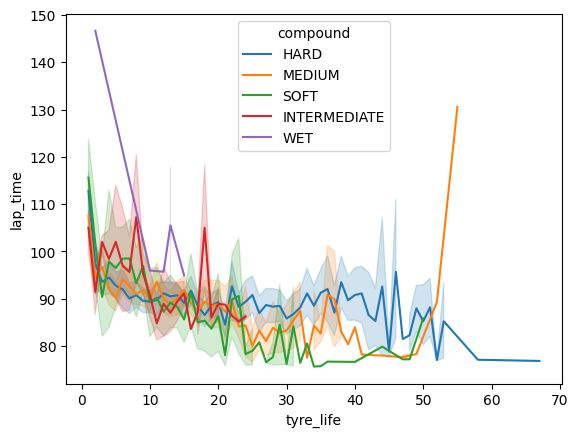

In [10]:
df_eval=df.loc[y_test.index].copy()
df_eval['pred']=best['preds']
sns.lineplot(data=df_eval,x='tyre_life',y='lap_time',hue='compound')

## Weather effect analysis

<Axes: xlabel='track_temp', ylabel='lap_time'>

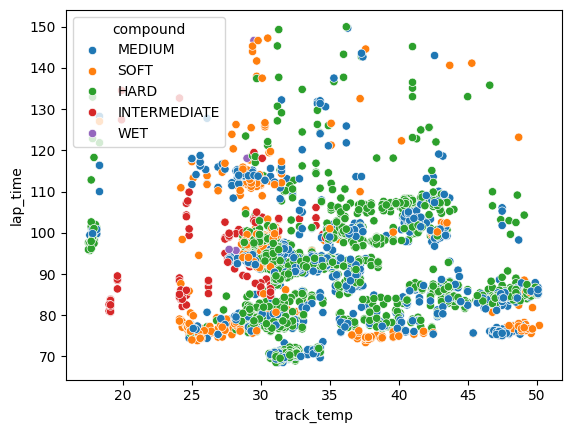

In [11]:
sns.scatterplot(data=df_eval.sample(min(3000,len(df_eval))),x='track_temp',y='lap_time',hue='compound')

## Driver degradation analysis

<Axes: xlabel='tyre_life', ylabel='lap_time'>

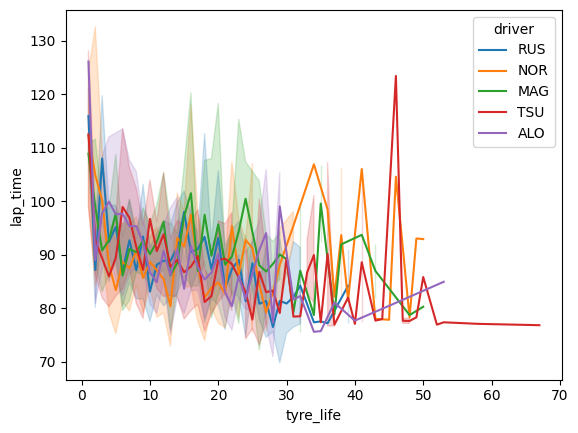

In [12]:
top=df_eval['driver'].value_counts().head(5).index
sns.lineplot(data=df_eval[df_eval['driver'].isin(top)],x='tyre_life',y='lap_time',hue='driver')

## Example model predictions

In [13]:
sample=X_train.iloc[0:1]
best['pipe'].predict(sample)

array([74.93169274])

## Save best model

In [14]:
import joblib
Path('models').mkdir(exist_ok=True)
joblib.dump(best['pipe'],'models/laptime_best_model.pkl')

['models/laptime_best_model.pkl']

## SHAP block

c:\Users\shrey\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 96%|=================== | 481/500 [00:15<00:00]       

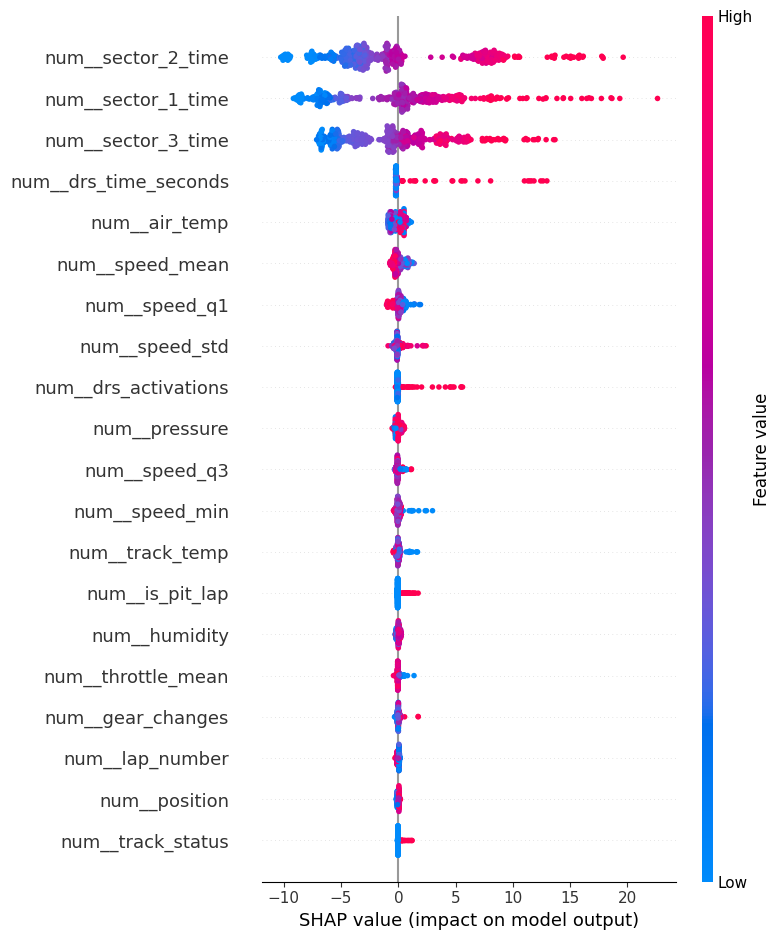

In [15]:
try:
    import shap
    Xs = pre.transform(X_train.sample(500))
    explainer=shap.Explainer(model,Xs)
    sv=explainer(Xs)
    shap.summary_plot(sv,features=Xs,feature_names=fn)
except Exception as e:
    print("SHAP failed:",e)